### Random Walk Centrality

Michael Goodrich
CS 575
January 2025

The purpose of this tutorial is to understand eigenvector centrality and its relation to random-walk centrality. Let's begin with an undirected graph.

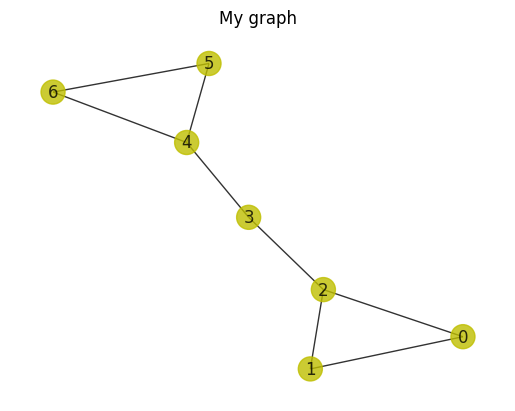

In [1]:
import networkx as nx
from network_utilities import show_graph

G: nx.Graph = nx.barbell_graph(3,1)
show_graph(G)

Install scipy into your local `venv` directory using something like 

`pip install scipy`

from the integrated terminal. We'll need this module because the networkx utility for returning the adjacency matrix for a graph returns a data structure called a _sparse matrix_.


Let's get the adjacency matrix for this graph and inspect it. We'll read the adjacency matrix as a sparse array using `nx.adjacency_matrix` and then convert it into a regular numpy array using `toarray`.

In [2]:
import numpy as np
import scipy

A: np.array = nx.adjacency_matrix(G, nodelist = sorted(G.nodes)).toarray()
print(A)

[[0 1 1 0 0 0 0]
 [1 0 1 0 0 0 0]
 [1 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 0 0 1 0 1 1]
 [0 0 0 0 1 0 1]
 [0 0 0 0 1 1 0]]


Recall that a $1$ in row $i$ and column $j$ of the adjacency matrix means that there is an edge from vertex $i$ and vertex $j$. Let's look at the third row, which represents the vertices adjacent to vertex 2. I've set it up so that the node number matches the row and column indices of the numpy array, and the numbering of numpy arrays begins at zero.

In [3]:
print(A[2,:])

[1 1 0 1 0 0 0]


Let's normalize that row by the row sum so that each non-zero entry of this matrix row sums to one: 

$$\hat{A}_{ij} = \frac{A_{ij}}{\sum_{j=1}^n A_{ij}}$$

When we do this for row 2 we get

In [4]:
row_2: np.array = A[2,:] / np.sum(A[2,:])
print(row_2)

[0.33333333 0.33333333 0.         0.33333333 0.         0.
 0.        ]


We can now interpret the entries of this row as probabilities. More specifically, we can think of these as _random walk_ probabilities. 

Suppose that a person is standing on vertex 2 and will randomly travel down one of the edges incident to vertex 2. There is a 1/3 chance of traveling to vertex 1, a 1/3 change of traveling to vertex 0, and a 1/3 chance of traveling to vertex 3. 

Let's normalize all the rows, using code from copilot.

In [5]:
A_hat: np.array = A / A.sum(axis=1, keepdims=True)
[print(f"row {row} = {np.round(A_hat[row, :],2)}") for row in sorted(G.nodes())]

row 0 = [0.  0.5 0.5 0.  0.  0.  0. ]
row 1 = [0.5 0.  0.5 0.  0.  0.  0. ]
row 2 = [0.33 0.33 0.   0.33 0.   0.   0.  ]
row 3 = [0.  0.  0.5 0.  0.5 0.  0. ]
row 4 = [0.   0.   0.   0.33 0.   0.33 0.33]
row 5 = [0.  0.  0.  0.  0.5 0.  0.5]
row 6 = [0.  0.  0.  0.  0.5 0.5 0. ]


[None, None, None, None, None, None, None]

Notice that the probability of transitioning from vertex 2 to vertex 3 is different from the probability of transitioning from vertex 3 to vertex 2. This is because there are three places the person can ranomly walk from vertex 2 but on ly two places from vertex 3.

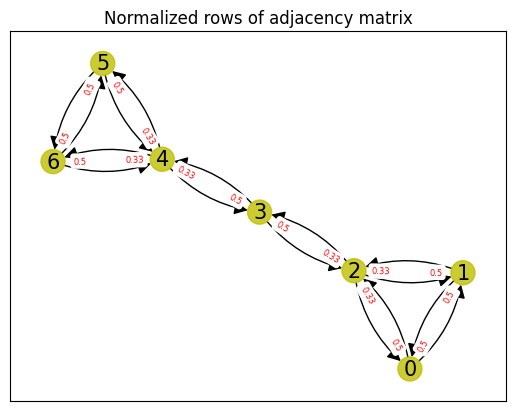

In [6]:
from network_utilities import show_digraph_with_edge_labels
from typing import Tuple
import networkx as nx

H: nx.digraph = nx.DiGraph()
H.add_nodes_from(list(range(len(G.nodes))))

edge_labels: dict[Tuple[int, int], float] = dict()
for edge in G.edges():
    H.add_edge(edge[0], edge[1])
    edge_labels[(edge[0],edge[1])] = np.round(A_hat[edge[0],edge[1]],2)
    H.add_edge(edge[1], edge[0])
    edge_labels[(edge[1],edge[0])] = np.round(A_hat[edge[1],edge[0]],2)
show_digraph_with_edge_labels(H,
                              title = "Normalized rows of adjacency matrix",
                              edge_labels = edge_labels)


The numbers closest to the vertex are the probabilities of transitioning from that vertex to the neighboring vertex. 

---

Let's suppose that we put a person randomly at one of the vertices according to the probability vector ${\mathbf p}$. To make the example concrete, let's suppose that the person starts at vertex 1. Then 

$${\mathbf p} = \left[1, 0, 0, 0, 0, 0, 0\right]^T $$

Notice the superscript $T$, indicating transpose. This means that the probability vector is a _column vector_.

Let's look at the first row of $\hat{A}$, which is 
$\left[ 
    \begin{array}{ccccccc} 
    0 &  \frac{1}{2} & \frac{1}{2} & 0 &  0 &  0 &  0 
    \end{array}
\right]. $ This row says that if the agent starts at vertex 0 (the row vertex) then each column represents the probability of moving to the column vertex. Thus, $\hat{A}_{ij}$ is the probability that an agent transitions from vertex $i$ to vertex $j$ on a random walk. 

We are working toward a matrix multiplication problem, and it will be better if we take the transition of $\hat{A}$. This means that the first column of 
$\hat{A}^T = \left[ 
    \begin{array}{ccccccc} 
    0 &  \frac{1}{2} & \frac{1}{2} & 0 &  0 &  0 &  0 
    \end{array}
\right]^T. $ Notice the transpose, making the right had side of the equation a column vector. We can interpret the value at the $i^{\rm th}$ row and $j^{\rm th}$ column of $\hat{A}^T$ as the transition probability from the $j^{\rm th}$ vertex the $i^{\rm th}$ row. The entries in this matrix represent  transition probabilities from the column verties to the row vertices. 



We can write the probability distribution at time $t$ as a function of the normalized matrix (transposed) $\hat{A}^T$ since this matrix acts as a transition probability. Let ${\mathbf p}(t)$ be the probability distribution at time $t$. The initial probability distribution is

$${\mathbf p}(0) = \left[1, 0, 0, 0, 0, 0, 0\right]^T $$

The probability at time $t$ is then given by 

$$ {\mathbf p}(t+1) = \hat{A}^T{\mathbf p}(t) $$

Let's write out what the right hand side of this equation means.

$$ {\mathbf p}(t+1) = \hat{A}^T {\mathbf p} = 
\left[ 
    \begin{array}{ccccccc} 
    0    & 1/2 & 1/3 & 0   & 0   & 0   & 0   \\
    1/2 & 0    & 1/3 & 0   & 0   & 0   & 0   \\
    1/2 & 1/2  & 0   & 1/2 & 0   & 0   & 0   \\
    0   & 0    & 1/3 & 0   & 1/3 & 0   & 0   \\
    0   & 0    & 0   & 1/2 & 0   & 1/2 & 0   \\
    0   & 0    & 0   & 0   & 1/3 & 0   & 1/2 \\
    0   & 0    & 0   & 0   & 1/3 & 1/2 & 1/2 \\
    \end{array}
\right] 
\left[ 
    \begin{array}{c}
        1 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 
    \end{array}
\right] = 
\left[ 
    \begin{array}{c}
        0 \\ 1/2 \\ 1/2 \\ 0 \\ 0 \\ 0 \\ 0 
    \end{array}
\right] $$

To summarize, when we put the initial probability distribution into a column vector and pre-multiply it by the transpose of the (row) normalized adjacency matrix we get the distribution of the probability at the next time step. For the example above, if the agent begins at vertex 0 and takes one random step, there is a $1/2$ probability of moving to vertex 1 and a $1/2$ probability of moving to vertex 2. That matches what we see on the graph.


I'd like to animate this, so let's create an animation class.

In [7]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Tuple, Any
from IPython import display

class Animation_Handler:
    def __init__(self,
                 G: nx.Graph,
                 node_positions: dict[Any, Tuple[float, float]]) -> None:
        self.node_positions = node_positions
        self.G = G

    def init_plot(self,
                  probability: np.array) -> None:
        desired_node_size = 200
        plt.figure(figsize=(3,3))
        ax = plt.gca()
        nx.draw(self.G,
                pos = self.node_positions,
                node_size=desired_node_size,
                node_color = probability,
                cmap = 'cool',
                font_color = 'white',
                alpha=0.8,
                with_labels = True)
        ax.set_title("Probability over time")
        sm = plt.cm.ScalarMappable(cmap = 'cool',
                                   norm=plt.Normalize(vmin = 0, vmax=1))
        _ = plt.colorbar(sm, ax=plt.gca())
    
    def update_plot(self,
                    probability: np.array) -> None:
        desired_node_size = 200
        nx.draw_networkx_nodes(self.G,
                pos = self.node_positions,
                node_size=desired_node_size,
                node_color = probability,
                cmap = 'cool',
                vmin=0,
                vmax = 1,
                alpha=0.8)
        nx.draw_networkx_labels(self.G, self.node_positions, font_color='white')
        
        display.display(plt.gcf())
        time.sleep(0.4)
        display.clear_output(wait=True)

Run the simulation and watch the probability disperse over the graph. Start the agent at vertex 0.

Multiple $\hat{A}^T {\mathbf p}$ multiple times, using colors to indicate how much probability is in each vertex at each time step. 

In [8]:
p: np.array = np.zeros([len(G.nodes),1])
p[0] = 1

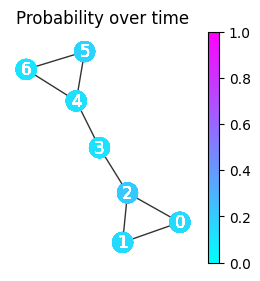

In [9]:
animation: Animation_Handler = Animation_Handler(G, nx.nx_pydot.graphviz_layout(G,prog='neato'))
t = 0
dt = 1
duration = 20

_ = animation.init_plot(p)

while (t<=duration):
    animation.update_plot(p)
    p = A_hat.T@p
    t += dt

Show the final probability distribution

In [10]:
print(p)

[[0.1366444 ]
 [0.13664488]
 [0.20093243]
 [0.12486917]
 [0.17435358]
 [0.11327777]
 [0.11327777]]


The key observation from this example is that the probability distribution reaches a stead state. This means that ${\mathbf p}(t)$ stops changing as $t \rightarrow \infty$. In the limit, the dynamics equation becomes

$${\mathbf p} = \hat{A}^T {\mathbf p}$$

This equation is just an eigenvalue equation for $\lambda = 1$.

---

Let's repeat but with a uniform initial distribution.

In [11]:
p: np.array = np.ones([len(G.nodes),1])
p = p / np.sum([p])
print(p)

[[0.14285714]
 [0.14285714]
 [0.14285714]
 [0.14285714]
 [0.14285714]
 [0.14285714]
 [0.14285714]]


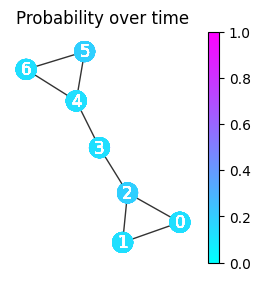

In [12]:
animation: Animation_Handler = Animation_Handler(G, nx.nx_pydot.graphviz_layout(G,prog='neato'))
t = 0
dt = 1
duration = 20

_ = animation.init_plot(p)

while (t<=duration):
    animation.update_plot(p)
    p = A_hat.T@p
    t += dt

In [13]:
print(np.round(p,4))

[[0.125 ]
 [0.125 ]
 [0.1876]
 [0.125 ]
 [0.1876]
 [0.125 ]
 [0.125 ]]


Let's compare the the eigenvectors of the adjacency matrix.

In [14]:
[eval, evec] = np.linalg.eig(A_hat.T)
for i in range(len(G.nodes)):
    print(f"eigenvalue {np.round(eval[i],2)} has eigenvector {np.round(evec[:,i]/np.sum(evec[:,i]),3)}")

eigenvalue 1.0 has eigenvector [0.125 0.125 0.188 0.125 0.187 0.125 0.125]
eigenvalue 0.88 has eigenvector [-3.65556180e+13 -3.65556180e+13 -4.15805023e+13  1.06000000e-01
  4.15805023e+13  3.65556180e+13  3.65556180e+13]
eigenvalue 0.23 has eigenvector [ 5.44332258e+14  5.44332258e+14 -4.43009892e+14 -1.29130925e+15
 -4.43009892e+14  5.44332258e+14  5.44332258e+14]
eigenvalue -0.73 has eigenvector [ 1.45354640e+14  1.45354640e+14 -5.35797649e+14  4.90176738e+14
 -5.35797649e+14  1.45354640e+14  1.45354640e+14]
eigenvalue -0.38 has eigenvector [-inf -inf  inf  inf -inf  inf  inf]
eigenvalue -0.5 has eigenvector [-2.98849542e+15  2.98849542e+15  4.15700000e+00 -1.85900000e+00
 -1.86600000e+00  1.22300000e+00  1.22300000e+00]
eigenvalue -0.5 has eigenvector [ inf -inf  inf  inf -inf -inf  inf]


/var/folders/7n/9nnbl1td6sq50rrh09m9x1v80000gn/T/ipykernel_25794/899041444.py:3: RuntimeWarning: divide by zero encountered in divide
  print(f"eigenvalue {np.round(eval[i],2)} has eigenvector {np.round(evec[:,i]/np.sum(evec[:,i]),3)}")
